In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BusinessMonthEnd

# === CONFIG ===
start_date = "2006-01-01"
end_date   = "2021-12-31"
base_value = 100.0
wiki_url   = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# 1) Get constituents
sp500       = pd.read_html(wiki_url)[0]
comm_tcks   = sp500[sp500["GICS Sector"] == "Communication Services"]["Symbol"].tolist()
real_tcks   = sp500[sp500["GICS Sector"] == "Real Estate"]["Symbol"].tolist()
all_tcks    = list(set(comm_tcks + real_tcks))

all_tcks


['O',
 'VICI',
 'T',
 'MAA',
 'FRT',
 'HST',
 'KIM',
 'DOC',
 'VTR',
 'TKO',
 'CPT',
 'UDR',
 'SPG',
 'AVB',
 'EA',
 'OMC',
 'CMCSA',
 'META',
 'FOX',
 'NWSA',
 'VZ',
 'LYV',
 'BXP',
 'CBRE',
 'PLD',
 'CCI',
 'EXR',
 'GOOGL',
 'EQR',
 'NWS',
 'ESS',
 'REG',
 'PARA',
 'DIS',
 'TTWO',
 'CHTR',
 'GOOG',
 'IRM',
 'WY',
 'AMT',
 'DLR',
 'NFLX',
 'ARE',
 'FOXA',
 'CSGP',
 'INVH',
 'WELL',
 'WBD',
 'SBAC',
 'MTCH',
 'EQIX',
 'PSA',
 'IPG',
 'TMUS']

In [4]:

# 2) Download price history
ohlc   = yf.download(all_tcks, start=start_date, end=end_date, auto_adjust=False)
prices = ohlc['Adj Close'].dropna(how='all')

# 3) Fetch float shares (static)
float_shares = {
    t: yf.Ticker(t).info.get("floatShares", np.nan)
    for t in all_tcks
}
float_shares = pd.Series(float_shares).dropna()


[*********************100%***********************]  54 of 54 completed


/var/folders/r4/bpvrknrd5mv0mfm2zd9tfsx40000gn/T/ipykernel_11741/2067072895.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = period_prices.pct_change().iloc[1:]
/var/folders/r4/bpvrknrd5mv0mfm2zd9tfsx40000gn/T/ipykernel_11741/2067072895.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = period_prices.pct_change().iloc[1:]
/var/folders/r4/bpvrknrd5mv0mfm2zd9tfsx40000gn/T/ipykernel_11741/2067072895.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior 

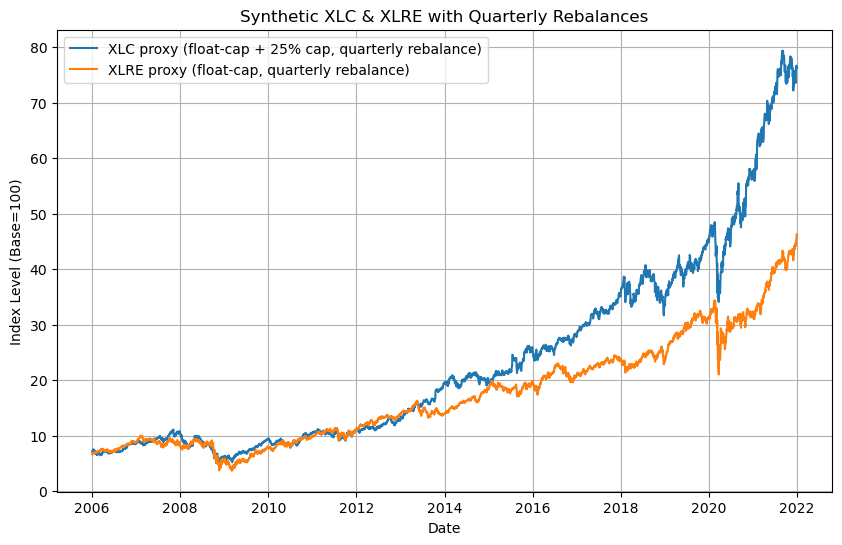

In [ ]:

# align tickers that have a float
prices = prices[float_shares.index]

# 4) Determine quarterly rebalance dates (last biz‑day of Feb/May/Aug/Nov)
months = [2, 5, 8, 11]
years  = range(prices.index.year.min(), prices.index.year.max()+1)
rdates = []
for y in years:
    for m in months:
        # first of month
        d = pd.Timestamp(year=y, month=m, day=1) + BusinessMonthEnd(0)
        # if market was open that day, keep; otherwise backfill to prior date in index
        if d in prices.index:
            rdates.append(d)
        else:
            # last price date before d
            prev = prices.index[prices.index < d]
            if len(prev): rdates.append(prev[-1])
rdates = sorted([d for d in rdates if d>=prices.index[0] and d<=prices.index[-1]])

# 5) Build index series period by period
def build_sector_index(tickers, cap_limit=None):
    idx = pd.Series(dtype=float, index=prices.index)
    idx.iloc[0] = base_value

    # split into periods
    period_starts = [prices.index[0]] + rdates
    period_ends   = rdates + [prices.index[-1]]

    for t0, t1 in zip(period_starts, period_ends):
        # get slice of prices for this period
        period_prices = prices.loc[t0:t1, tickers]

        # compute float‐caps at t0
        caps_t0 = float_shares[tickers] * period_prices.iloc[0]
        w = caps_t0 / caps_t0.sum()

        # apply cap if needed (e.g. 25% for XLC)
        if cap_limit is not None:
            # cap & redistribute
            def cap_and_redistribute(w, limit):
                w = w.copy()
                over = w > limit
                while over.any():
                    excess = w[over] - limit
                    w[over] = limit
                    # redistribute excess to those < limit
                    under = ~over
                    total_under = w[under].sum()
                    w[under] += (excess.sum() * (w[under] / total_under))
                    over = w > limit
                return w
            w = cap_and_redistribute(w, cap_limit)

        # now simulate index for t > t0
        prev_idx = idx.loc[t0]
        # daily returns within period
        ret = period_prices.pct_change().iloc[1:]
        # portfolio daily return
        port_ret = ret.mul(w, axis=1).sum(axis=1)
        # build index
        idx.loc[port_ret.index] = prev_idx * (1 + port_ret).cumprod()

    return idx

# 6) Build both series
xlc_proxy = build_sector_index(comm_tcks, cap_limit=0.25)
xlre_proxy= build_sector_index(real_tcks)

# Rescale so final value matches the real XLRE closing price on Dec 30, 2021
real_final_price = 46.304500579833984
synthetic_final_price = xlre_proxy.loc["2021-12-30"]
scaling_factor = real_final_price / synthetic_final_price

# Rescale synthetic XLC to match the real ETF price at 2021-12-30
real_xlc_price = 76.2320785522461  # Actual adjusted close price for XLC on Dec 30, 2021
synthetic_xlc_final = xlc_proxy.loc["2021-12-30"]
scaling_factor_xlc = real_xlc_price / synthetic_xlc_final

# Apply the scaling
xlc_proxy *= scaling_factor_xlc
xlre_proxy *= scaling_factor


# 7) Plot
plt.figure(figsize=(10,6))
plt.plot(xlc_proxy, label="XLC proxy (float‑cap + 25% cap, quarterly rebalance)")
plt.plot(xlre_proxy, label="XLRE proxy (float‑cap, quarterly rebalance)")
plt.title("Synthetic XLC & XLRE with Quarterly Rebalances")
plt.xlabel("Date")
plt.ylabel("Index Level (Base=100)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import os
import pandas as pd

# Folder path where sector data is stored
folder_path = "/Users/benjaminli/Code/MyTradingProjects/DRL_Portfolio_Optimisation/DRL-Portfolio-Optimisation/data"
os.makedirs(folder_path, exist_ok=True)

# Function to save with custom second row showing the ticker
def save_with_custom_header(data, ticker_name):
    df = data.to_frame(name="Adj Close")
    
    # Reset index so date is a column
    df_reset = df.reset_index()
    df_reset.columns = ["Date", "Adj Close"]

    # Create a second row with the ticker name under 'Adj Close'
    header = pd.DataFrame([["", ticker_name]], columns=["Date", "Adj Close"])

    # Combine header and data
    final_df = pd.concat([header, df_reset], ignore_index=True)

    # Save to CSV
    final_df.to_csv(os.path.join(folder_path, f"{ticker_name}.csv"), index=False)

# Save both XLC and XLRE with custom format
save_with_custom_header(xlc_proxy, "XLC")
save_with_custom_header(xlre_proxy, "XLRE")




Date,Adj Close,Close,High,Low,Open,Volume
,XLC,XLC,XLC,XLC,XLC,XLC
2018-06-19,46.898738861083984,49.959999084472656,50.060001373291016,49.58000183105469,49.70000076293945,16600
2018-06-20,47.480743408203125,50.58000183105469,50.888999938964844,50.45000076293945,50.45000076293945,190000
2018-06-21,47.18974304199219,50.27000045776367,50.849998474121094,50.20000076293945,50.77000045776367,428700
2018-06-22,47.396263122558594,50.4900016784668,50.61000061035156,50.189998626708984,50.59000015258789,181500
2018-06-25,46.41999053955078,49.45000076293945,50.22999954223633,49.01499938964844,50.22999954223633,2509600
2018-06-26,46.49697494506836,49.53200149536133,49.779998779296875,49.349998474121094,49.720001220703125,104000
2018-06-27,46.09143829345703,49.099998474121094,50.0,49.099998474121094,49.81999969482422,144900
2018-06-28,46.55140686035156,49.59000015258789,49.790000915527344,48.970001220703125,49.099998474121094,336500
2018-06-29,46.49509048461914,49.529998779296875,49.84000015258789,49.41999816894531,49.79999923706055,152300
2018-07-02,46.78608322143555,49.84000015258789,49.84000015258789,48.939998626708984,49.11000061035156,321300
2018-07-03,46.21346664428711,49.22999954223633,50.0,49.18899917602539,50.0,97500
2018-07-05,46.91750717163086,49.97999954223633,50.0,49.33000183105469,49.59000015258789,324900
2018-07-06,47.659114837646484,50.77000045776367,50.816001892089844,49.93000030517578,50.13999938964844,199800
2018-07-09,47.931331634521484,51.060001373291016,51.20000076293945,50.650001525878906,51.20000076293945,118100
2018-07-10,47.911624908447266,51.03900146484375,51.209999084472656,50.869998931884766,51.209999084472656,1153200
2018-07-11,47.84685516357422,50.970001220703125,51.22999954223633,50.650001525878906,50.70000076293945,227500
2018-07-12,48.59782028198242,51.77000045776367,51.77000045776367,51.13999938964844,51.29999923706055,361400
2018-07-13,48.52273178100586,51.689998626708984,51.79999923706055,51.44900131225586,51.779998779296875,80100
2018-07-16,48.381927490234375,51.540000915527344,51.779998779296875,51.45000076293945,51.779998779296875,200700
2018-07-17,48.39131546020508,51.54999923706055,51.68000030517578,50.720001220703125,50.810001373291016,172600
2018-07-18,48.25050354003906,51.400001525878906,51.599998474121094,51.22999954223633,51.59000015258789,147800
2018-07-19,47.91256332397461,51.040000915527344,51.470001220703125,51.00600051879883,51.43000030517578,258400
2018-07-20,47.75297546386719,50.869998931884766,51.18600082397461,50.84000015258789,51.04999923706055,158400
2018-07-23,47.950111389160156,51.08000183105469,51.099998474121094,50.650001525878906,50.93000030517578,94800
2018-07-24,48.28805923461914,51.439998626708984,52.11000061035156,51.15999984741211,52.11000061035156,211200
2018-07-25,48.635372161865234,51.810001373291016,51.875,51.380001068115234,51.529998779296875,604300


Date,Adj Close,Close,High,Low,Open,Volume
,XLRE,XLRE,XLRE,XLRE,XLRE,XLRE
2015-10-08,21.775779724121094,30.209999084472656,30.209999084472656,30.010000228881836,30.010000228881836,2000
2015-10-09,21.739749908447266,30.15999984741211,30.200000762939453,30.059999465942383,30.200000762939453,4300
2015-10-12,21.876707077026367,30.350000381469727,30.420000076293945,30.270000457763672,30.420000076293945,2300
2015-10-13,21.739749908447266,30.15999984741211,30.15999984741211,30.15999984741211,30.15999984741211,500
2015-10-14,21.739749908447266,30.15999984741211,30.15999984741211,30.15999984741211,30.15999984741211,0
2015-10-15,21.674877166748047,30.06999969482422,30.06999969482422,30.030000686645508,30.030000686645508,2500
2015-10-16,22.087181091308594,30.642000198364258,30.65999984741211,30.59600067138672,30.59600067138672,400
2015-10-19,22.34522819519043,31.0,31.010000228881836,30.700000762939453,30.700000762939453,2000
2015-10-20,22.366853713989258,31.030000686645508,31.360000610351562,30.989999771118164,31.360000610351562,3200
2015-10-21,22.384878158569336,31.05500030517578,31.05500030517578,31.05500030517578,31.05500030517578,400
2015-10-22,22.66815757751465,31.447999954223633,31.46299934387207,31.177000045776367,31.18000030517578,2200
2015-10-23,22.395689010620117,31.06999969482422,31.06999969482422,30.940000534057617,31.05299949645996,3500
2015-10-26,22.42452049255371,31.110000610351562,31.1200008392334,31.027999877929688,31.027999877929688,600
2015-10-27,22.430286407470703,31.118000030517578,31.1200008392334,31.0,31.059999465942383,3400
2015-10-28,22.34883689880371,31.0049991607666,31.329999923706055,31.0049991607666,31.239999771118164,3200
2015-10-29,22.45047378540039,31.145999908447266,31.145999908447266,31.010000228881836,31.030000686645508,3900
2015-10-30,22.309192657470703,30.950000762939453,30.950000762939453,30.950000762939453,30.950000762939453,200
2015-11-02,22.309192657470703,30.950000762939453,30.950000762939453,30.950000762939453,30.950000762939453,100
2015-11-03,22.597517013549805,31.350000381469727,31.600000381469727,31.31999969482422,31.600000381469727,500
2015-11-04,22.503808975219727,31.219999313354492,31.520000457763672,31.219999313354492,31.520000457763672,1900
2015-11-05,22.417312622070312,31.100000381469727,31.280000686645508,30.950000762939453,31.280000686645508,23800
2015-11-06,21.588376998901367,29.950000762939453,30.3799991607666,29.950000762939453,30.3799991607666,9000
2015-11-09,21.41537857055664,29.709999084472656,30.104000091552734,29.600000381469727,30.059999465942383,45500

